# Confusion Matrix for ResNet Model

This notebook creates a confusion matrix to evaluate the ResNet classification model performance on test data.

In [13]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import json
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings

# PyTorch libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Setup Device and Load Model

In [14]:
# Setup device (GPU/MPS/CPU)
def setup_device():
    """Setup device for inference (CUDA/MPS/CPU)"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ Using MPS (Apple Silicon)")
    else:
        device = torch.device('cpu')
        print("⚠ Using CPU")
    return device

device = setup_device()

# Load model info and label mappings
model_dir = Path('./models/resnet')

# Load model info
with open(model_dir / 'model_info.json', 'r') as f:
    model_info = json.load(f)

# Load label mappings
with open(model_dir / 'label_mappings.json', 'r') as f:
    label_mappings = json.load(f)

# Extract information
idx_to_label = {int(k): v for k, v in label_mappings['idx_to_label'].items()}
label_to_idx = label_mappings['label_to_idx']
num_classes = model_info['num_classes']
img_size = model_info['img_size']

print(f"\nModel Configuration:")
print(f"  Image size: {img_size}x{img_size}")
print(f"  Number of classes: {num_classes}")
print(f"  Test accuracy (from training): {model_info.get('test_accuracy', 'N/A')}")
print(f"  Test top-3 accuracy (from training): {model_info.get('test_top3_accuracy', 'N/A')}")

✓ Using MPS (Apple Silicon)

Model Configuration:
  Image size: 160x160
  Number of classes: 340
  Test accuracy (from training): 0.7502549019607843
  Test top-3 accuracy (from training): 0.9070196078431373


## 2. Create and Load ResNet Model

In [15]:
def create_resnet_model(num_classes):
    """
    Create a ResNet18 model matching the training architecture
    """
    model = models.resnet18(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model

# Create model
model = create_resnet_model(num_classes)

# Load trained weights
model_path = model_dir / 'model.pth'
if not model_path.exists():
    raise FileNotFoundError(f"Model file not found: {model_path}")

model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.to(device)
model.eval()

print(f"✓ Model loaded successfully from {model_path}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Define transforms (matching training - ImageNet normalization)
# CRITICAL FIX: Training uses ImageNet normalization [0.485, 0.456, 0.406] / [0.229, 0.224, 0.225]
# NOT [0.5, 0.5, 0.5] / [0.5, 0.5, 0.5]. This mismatch causes terrible accuracy!
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

✓ Model loaded successfully from models/resnet/model.pth
  Total parameters: 11,614,612


## 3. Load Test Data

In [16]:
# Setup paths
doodle_dir = Path('doodles/doodle')

# Configuration
SAMPLES_PER_CATEGORY = 200  # Number of test samples per category

def load_test_images(categories, samples_per_category, image_size):
    """
    Load test images from disk and preprocess them for ResNet.
    ResNet expects RGB images (3 channels).
    """
    images = []
    labels = []
    image_paths = []
    
    for category in tqdm(categories, desc="Loading test images"):
        if category not in label_to_idx:
            continue
            
        category_path = doodle_dir / category
        if not category_path.exists():
            continue
            
        image_files = list(category_path.glob('*.png'))[:samples_per_category]
        
        for img_path in image_files:
            try:
                # Load image as RGB (matching training - no inversion)
                # The training dataset doesn't invert images, just loads RGB directly
                img = Image.open(img_path).convert('RGB')
                
                images.append(img)
                labels.append(category)
                image_paths.append(str(img_path))
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return images, np.array(labels), image_paths

# Get all categories that are in the model
all_categories = sorted([d.name for d in doodle_dir.iterdir() if d.is_dir()])
model_categories = [cat for cat in all_categories if cat in label_to_idx]

print(f"Loading test data from {len(model_categories)} categories...")
print(f"Samples per category: {SAMPLES_PER_CATEGORY}")

# Load test images
X_test_images, y_test_labels, test_paths = load_test_images(
    model_categories, SAMPLES_PER_CATEGORY, img_size
)

# Encode labels
y_test_encoded = np.array([label_to_idx[label] for label in y_test_labels])

print(f"\nLoaded {len(X_test_images)} test images")
print(f"Number of classes in test set: {len(np.unique(y_test_encoded))}")

Loading test data from 340 categories...
Samples per category: 200


Loading test images: 100%|██████████| 340/340 [00:31<00:00, 10.77it/s]



Loaded 68000 test images
Number of classes in test set: 340


## 4. Make Predictions

In [17]:
# Make predictions on test set
print("Making predictions on test set...")
y_pred_encoded = []

# Process in batches for efficiency
BATCH_SIZE = 64
model.eval()

with torch.no_grad():
    for i in tqdm(range(0, len(X_test_images), BATCH_SIZE), desc="Predicting"):
        batch_images = X_test_images[i:i+BATCH_SIZE]
        
        # Transform images
        batch_tensors = torch.stack([transform(img) for img in batch_images]).to(device)
        
        # Get predictions
        outputs = model(batch_tensors)
        _, predicted = torch.max(outputs, 1)
        
        y_pred_encoded.extend(predicted.cpu().numpy())

y_pred_encoded = np.array(y_pred_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Convert back to labels for better readability
y_test_label_names = [idx_to_label[idx] for idx in y_test_encoded]
y_pred_label_names = [idx_to_label[idx] for idx in y_pred_encoded]

Making predictions on test set...


Predicting: 100%|██████████| 1063/1063 [01:45<00:00, 10.08it/s]


Test Accuracy: 0.8183 (81.83%)


## 5. Create Confusion Matrix

In [18]:
# Create confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_encoded, labels=list(range(num_classes)))

print(f"Confusion matrix shape: {cm.shape}")
print(f"Total test samples: {len(y_test_encoded)}")
print(f"Correct predictions: {np.trace(cm)}")
print(f"Accuracy from confusion matrix: {np.trace(cm) / len(y_test_encoded):.4f}")

Confusion matrix shape: (340, 340)
Total test samples: 68000
Correct predictions: 55643
Accuracy from confusion matrix: 0.8183


## 6. Visualize Confusion Matrix (Full)

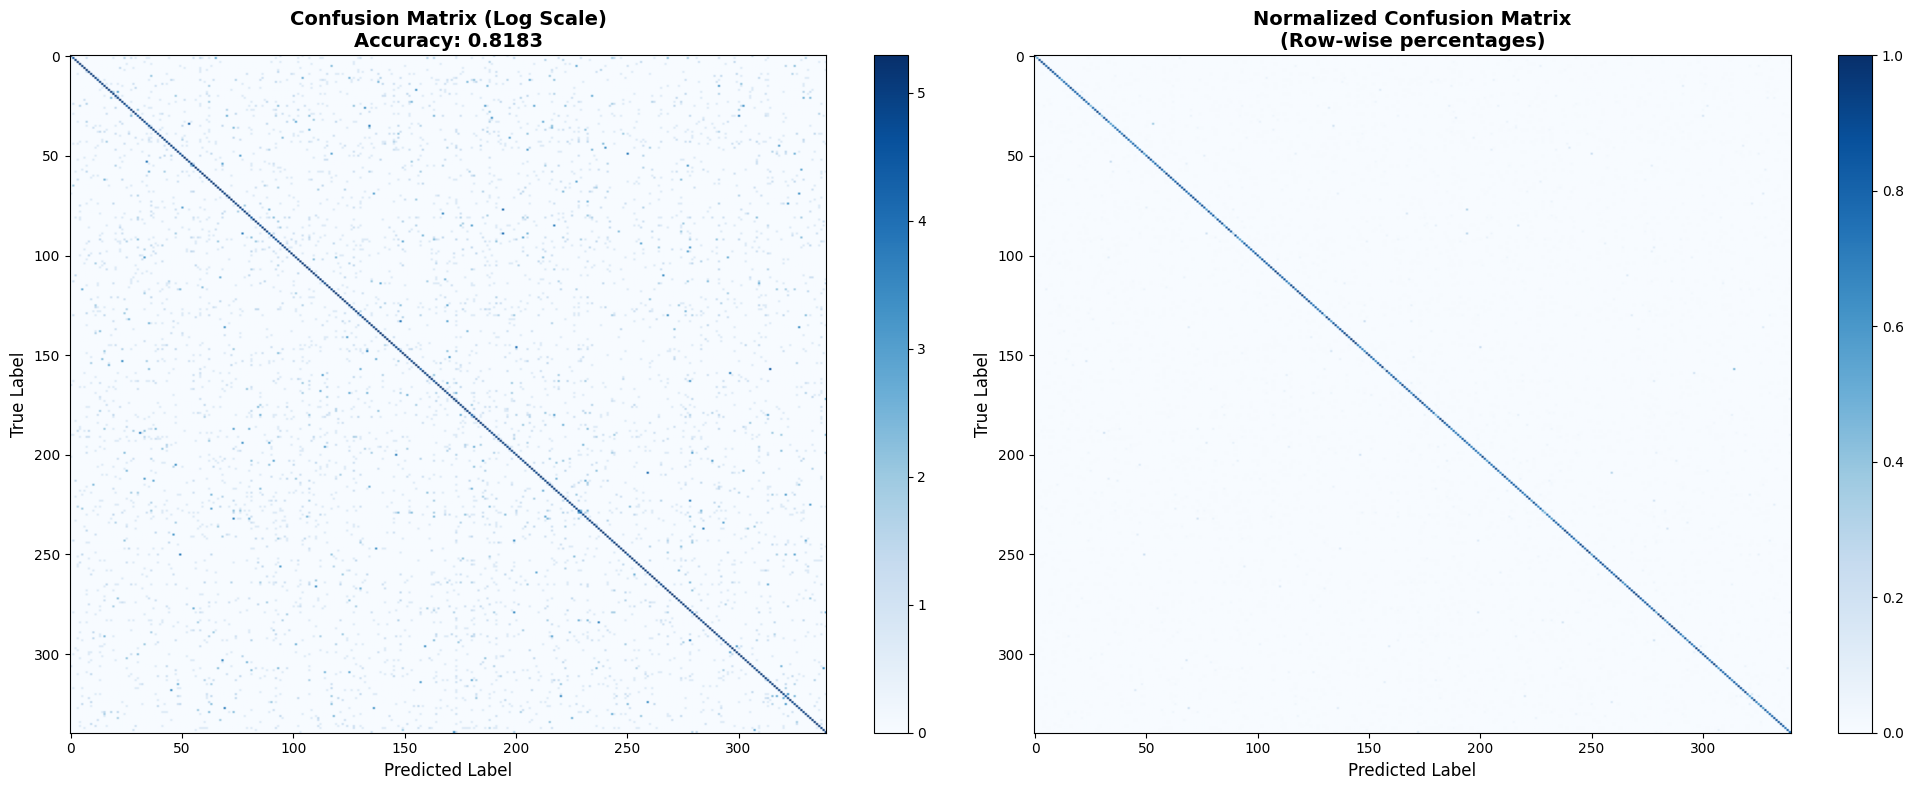


Note: Due to the large number of classes (340), individual labels are not shown.
The diagonal represents correct predictions.


In [19]:
# For 340 classes, the full confusion matrix is too large to visualize clearly
# We'll create a normalized version and show statistics

# Normalize confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot raw confusion matrix (log scale for better visibility)
cm_log = np.log1p(cm)  # log(1+x) to handle zeros
im1 = axes[0].imshow(cm_log, cmap='Blues', aspect='auto')
axes[0].set_title(f'Confusion Matrix (Log Scale)\nAccuracy: {accuracy:.4f}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
plt.colorbar(im1, ax=axes[0])

# Plot normalized confusion matrix
im2 = axes[1].imshow(cm_normalized, cmap='Blues', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Normalized Confusion Matrix\n(Row-wise percentages)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print("\nNote: Due to the large number of classes (340), individual labels are not shown.")
print("The diagonal represents correct predictions.")

## 7. Visualize Top Confused Classes

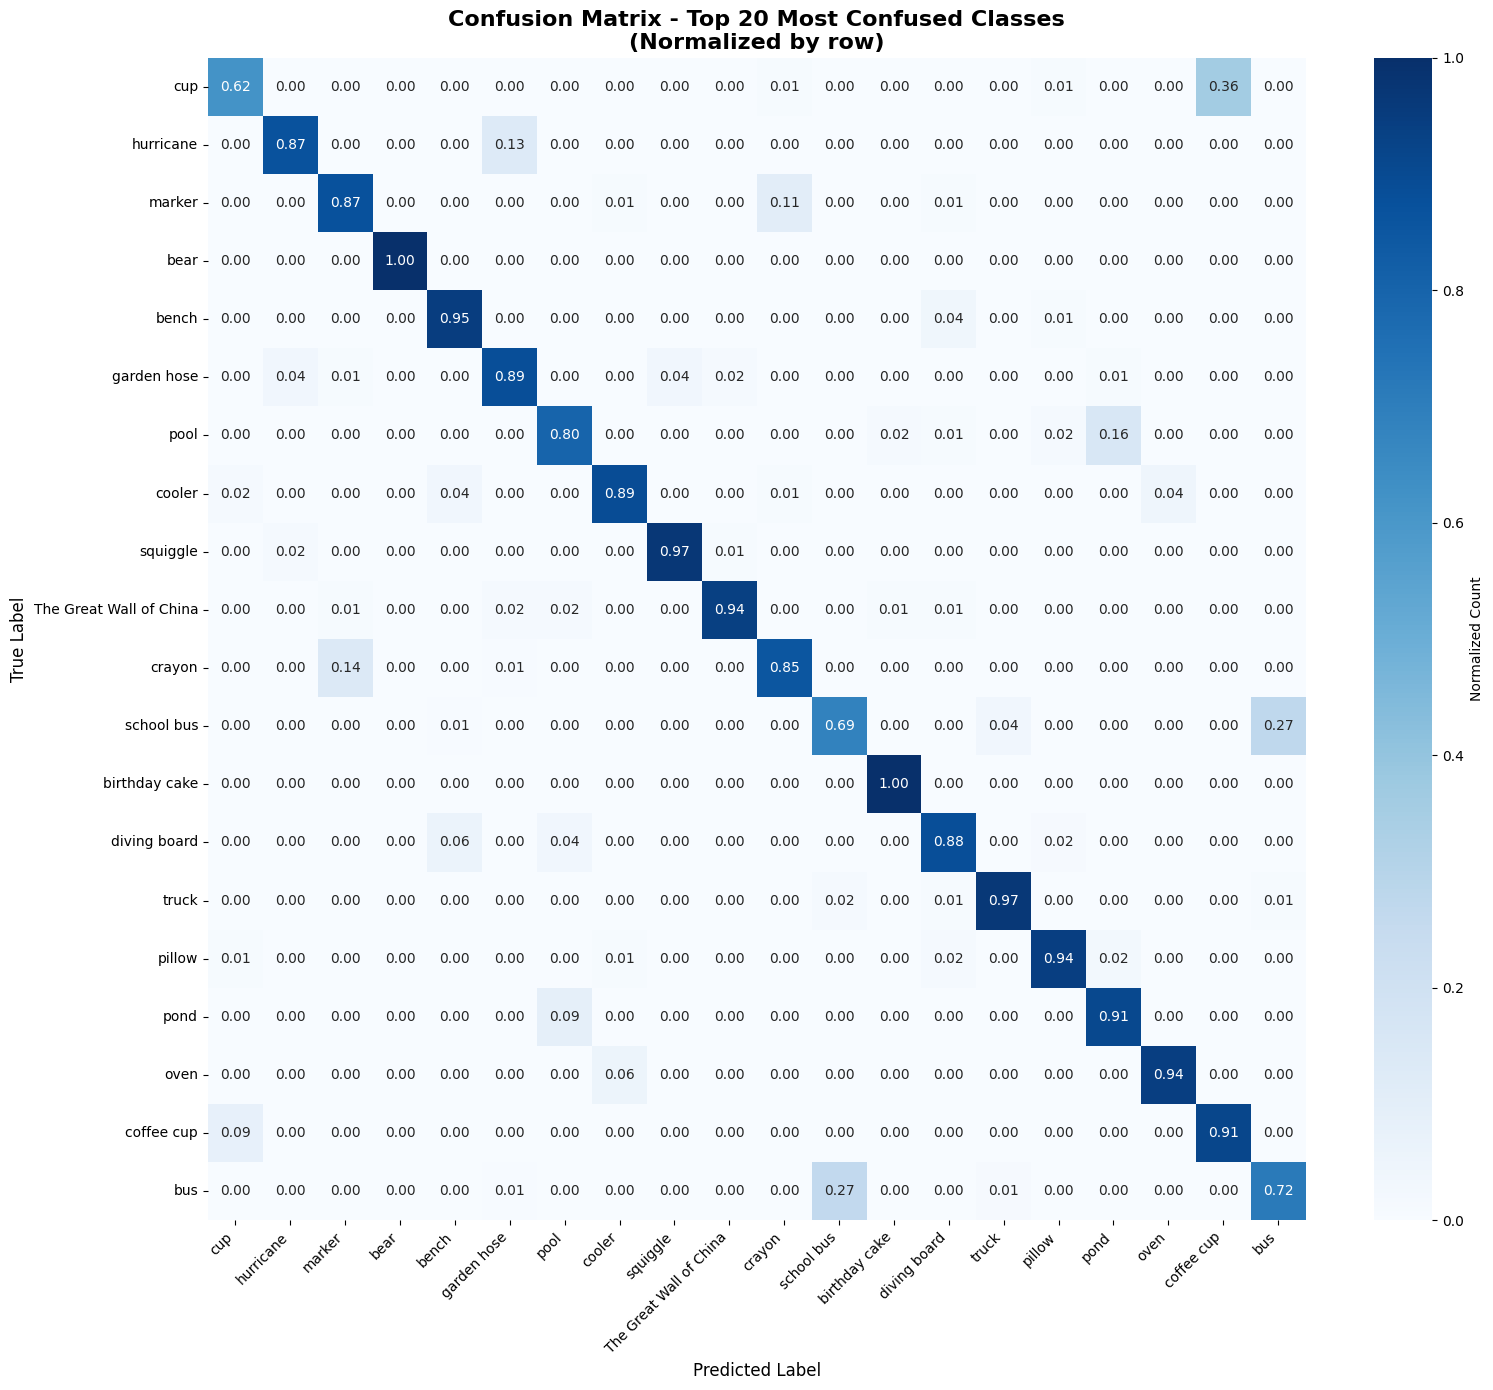


Top 20 classes with most errors:
cup                            | Total:  200 | Correct:   67 | Errors:  133 | Acc: 33.50%
hurricane                      | Total:  200 | Correct:   79 | Errors:  121 | Acc: 39.50%
marker                         | Total:  200 | Correct:   89 | Errors:  111 | Acc: 44.50%
bear                           | Total:  200 | Correct:   92 | Errors:  108 | Acc: 46.00%
bench                          | Total:  200 | Correct:   92 | Errors:  108 | Acc: 46.00%
garden hose                    | Total:  200 | Correct:   93 | Errors:  107 | Acc: 46.50%
pool                           | Total:  200 | Correct:   95 | Errors:  105 | Acc: 47.50%
cooler                         | Total:  200 | Correct:  100 | Errors:  100 | Acc: 50.00%
squiggle                       | Total:  200 | Correct:  102 | Errors:   98 | Acc: 51.00%
The Great Wall of China        | Total:  200 | Correct:  106 | Errors:   94 | Acc: 53.00%
crayon                         | Total:  200 | Correct:  110 | Err

In [20]:
# Find classes with most confusion (off-diagonal elements)
off_diagonal = cm.copy()
np.fill_diagonal(off_diagonal, 0)

# Get top N most confused classes
top_n = 20
class_totals = cm.sum(axis=1)
class_correct = np.diag(cm)
class_errors = class_totals - class_correct

# Get indices sorted by error count
top_error_indices = np.argsort(class_errors)[-top_n:][::-1]

# Create submatrix for top confused classes
cm_subset = cm[np.ix_(top_error_indices, top_error_indices)]
labels_subset = [idx_to_label[idx] for idx in top_error_indices]

# Plot subset confusion matrix
plt.figure(figsize=(16, 14))
cm_subset_normalized = cm_subset.astype('float') / cm_subset.sum(axis=1)[:, np.newaxis]
cm_subset_normalized = np.nan_to_num(cm_subset_normalized)

sns.heatmap(cm_subset_normalized, 
            annot=True, 
            fmt='.2f', 
            cmap='Blues',
            xticklabels=labels_subset,
            yticklabels=labels_subset,
            cbar_kws={'label': 'Normalized Count'})

plt.title(f'Confusion Matrix - Top {top_n} Most Confused Classes\n(Normalized by row)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print statistics for top confused classes
print(f"\nTop {top_n} classes with most errors:")
print("=" * 80)
for idx in top_error_indices:
    label = idx_to_label[idx]
    total = class_totals[idx]
    correct = class_correct[idx]
    errors = class_errors[idx]
    accuracy_class = correct / total if total > 0 else 0
    print(f"{label:30s} | Total: {total:4d} | Correct: {correct:4d} | Errors: {errors:4d} | Acc: {accuracy_class:.2%}")

## 8. Per-Class Accuracy Statistics

Per-Class Accuracy Statistics:
Mean accuracy: 0.8183
Median accuracy: 0.8375
Std deviation: 0.1179

Best performing classes:
         label  total_samples  correct  accuracy
        ladder            200      194     0.970
       mermaid            200      194     0.970
    skateboard            200      194     0.970
tennis racquet            200      195     0.975
   house plant            200      195     0.975
           saw            200      195     0.975
     stop sign            200      195     0.975
    headphones            200      195     0.975
          star            200      196     0.980
        stairs            200      198     0.990

Worst performing classes:
                  label  total_samples  correct  accuracy
                    cup            200       67     0.335
              hurricane            200       79     0.395
                 marker            200       89     0.445
                  bench            200       92     0.460
                   

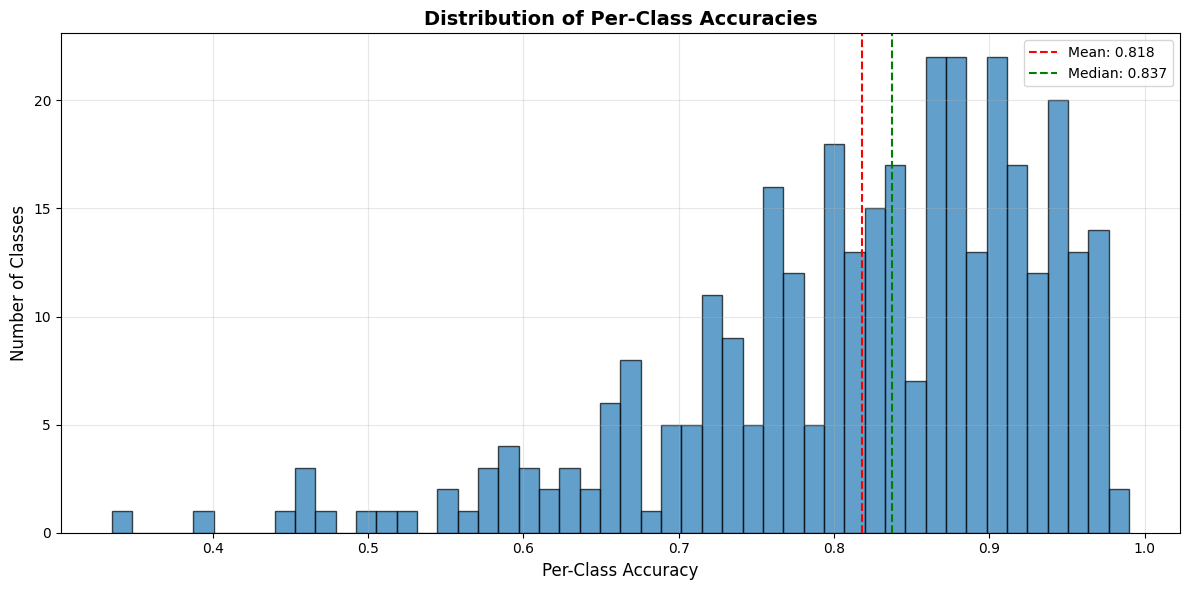

In [21]:
# Calculate per-class accuracy
class_accuracies = []
for idx in range(num_classes):
    total = cm.sum(axis=1)[idx]
    if total > 0:
        correct = cm[idx, idx]
        accuracy_class = correct / total
        class_accuracies.append({
            'class_idx': idx,
            'label': idx_to_label[idx],
            'total_samples': total,
            'correct': correct,
            'accuracy': accuracy_class
        })

# Convert to DataFrame
df_acc = pd.DataFrame(class_accuracies)
df_acc = df_acc.sort_values('accuracy')

# Display statistics
print("Per-Class Accuracy Statistics:")
print("=" * 80)
print(f"Mean accuracy: {df_acc['accuracy'].mean():.4f}")
print(f"Median accuracy: {df_acc['accuracy'].median():.4f}")
print(f"Std deviation: {df_acc['accuracy'].std():.4f}")
print(f"\nBest performing classes:")
print(df_acc.tail(10)[['label', 'total_samples', 'correct', 'accuracy']].to_string(index=False))
print(f"\nWorst performing classes:")
print(df_acc.head(10)[['label', 'total_samples', 'correct', 'accuracy']].to_string(index=False))

# Plot distribution of accuracies
plt.figure(figsize=(12, 6))
plt.hist(df_acc['accuracy'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Per-Class Accuracy', fontsize=12)
plt.ylabel('Number of Classes', fontsize=12)
plt.title('Distribution of Per-Class Accuracies', fontsize=14, fontweight='bold')
plt.axvline(df_acc['accuracy'].mean(), color='red', linestyle='--', label=f'Mean: {df_acc["accuracy"].mean():.3f}')
plt.axvline(df_acc['accuracy'].median(), color='green', linestyle='--', label=f'Median: {df_acc["accuracy"].median():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Classification Report

In [22]:
# Generate classification report
class_names = [idx_to_label[i] for i in range(num_classes)]
report = classification_report(y_test_encoded, y_pred_encoded, 
                               target_names=class_names,
                               output_dict=True,
                               zero_division=0)

print("Classification Report:")
print("=" * 80)
print(f"Overall Accuracy: {report['accuracy']:.4f}")
print(f"\nMacro Average:")
print(f"  Precision: {report['macro avg']['precision']:.4f}")
print(f"  Recall: {report['macro avg']['recall']:.4f}")
print(f"  F1-Score: {report['macro avg']['f1-score']:.4f}")
print(f"\nWeighted Average:")
print(f"  Precision: {report['weighted avg']['precision']:.4f}")
print(f"  Recall: {report['weighted avg']['recall']:.4f}")
print(f"  F1-Score: {report['weighted avg']['f1-score']:.4f}")

Classification Report:
Overall Accuracy: 0.8183

Macro Average:
  Precision: 0.8206
  Recall: 0.8183
  F1-Score: 0.8171

Weighted Average:
  Precision: 0.8206
  Recall: 0.8183
  F1-Score: 0.8171


## 10. Top-3 Accuracy Analysis

In [23]:
# Calculate top-3 accuracy
print("Calculating top-3 accuracy...")
top3_correct = 0

model.eval()
with torch.no_grad():
    for i in tqdm(range(0, len(X_test_images), BATCH_SIZE), desc="Top-3 predictions"):
        batch_images = X_test_images[i:i+BATCH_SIZE]
        batch_labels = y_test_encoded[i:i+BATCH_SIZE]
        
        # Transform images
        batch_tensors = torch.stack([transform(img) for img in batch_images]).to(device)
        
        # Get top-3 predictions
        outputs = model(batch_tensors)
        _, top3_pred = torch.topk(outputs, 3, dim=1)
        
        # Check if true label is in top-3
        for j, true_label in enumerate(batch_labels):
            if true_label in top3_pred[j].cpu().numpy():
                top3_correct += 1

top3_accuracy = top3_correct / len(y_test_encoded)
print(f"\nTop-3 Accuracy: {top3_accuracy:.4f} ({top3_accuracy*100:.2f}%)")
print(f"Top-1 Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Improvement: {(top3_accuracy - accuracy):.4f} ({(top3_accuracy - accuracy)*100:.2f}%)")

Calculating top-3 accuracy...


Top-3 predictions: 100%|██████████| 1063/1063 [01:52<00:00,  9.49it/s]


Top-3 Accuracy: 0.9469 (94.69%)
Top-1 Accuracy: 0.8183 (81.83%)
Improvement: 0.1286 (12.86%)


## 11. Save Results

In [24]:
# Save confusion matrix and results
output_dir = Path('results/resnet')
output_dir.mkdir(parents=True, exist_ok=True)

# Save confusion matrix as numpy array
np.save(output_dir / 'confusion_matrix.npy', cm)
np.save(output_dir / 'confusion_matrix_normalized.npy', cm_normalized)

# Save per-class accuracies
df_acc.to_csv(output_dir / 'per_class_accuracy.csv', index=False)

# Save summary statistics
summary = {
    'test_accuracy': float(accuracy),
    'test_top3_accuracy': float(top3_accuracy),
    'num_test_samples': int(len(y_test_encoded)),
    'num_classes': int(num_classes),
    'mean_per_class_accuracy': float(df_acc['accuracy'].mean()),
    'median_per_class_accuracy': float(df_acc['accuracy'].median()),
    'std_per_class_accuracy': float(df_acc['accuracy'].std()),
    'macro_avg_precision': float(report['macro avg']['precision']),
    'macro_avg_recall': float(report['macro avg']['recall']),
    'macro_avg_f1': float(report['macro avg']['f1-score']),
    'weighted_avg_precision': float(report['weighted avg']['precision']),
    'weighted_avg_recall': float(report['weighted avg']['recall']),
    'weighted_avg_f1': float(report['weighted avg']['f1-score'])
}

with open(output_dir / 'evaluation_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\nResults saved to {output_dir}/")
print(f"  - confusion_matrix.npy")
print(f"  - confusion_matrix_normalized.npy")
print(f"  - per_class_accuracy.csv")
print(f"  - evaluation_summary.json")


Results saved to results/resnet/
  - confusion_matrix.npy
  - confusion_matrix_normalized.npy
  - per_class_accuracy.csv
  - evaluation_summary.json
